# LioJotstar Merger: Data Analysis with Python for Strategic Optimization

## 7. Decoding User Inactivity: A Deep Dive into Engagement Gaps
This notebook investigates user inactivity patterns on LioCinema and Jotstar, categorizing inactive users and analyzing their distribution across platforms by age group, city tier, and subscription plan using horizontal and vertical grouped bar charts, population pyramids, and pie charts.

### Importing Required Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Required DataFrames from Saved Parquet Files

In [6]:
try:
    jotstar_subscribers_df = pd.read_parquet('Parquet Data Files/03. Feature Engineering/Jotstar_db/subscribers.parquet')
    print("Jotstar - Subscribers table loaded successfully.")
    liocinema_subscribers_df = pd.read_parquet('Parquet Data Files/03. Feature Engineering/LioCinema_db/subscribers.parquet')
    print("LioCinema - Subscribers table loaded successfully.")
    print("\nData Loading Complete.")
    
except FileNotFoundError as e:
       print("Error: One or more Parquet files not found. Please check the file paths.")
       print(f"Details: {e}")
except Exception as e:
       print("An error occurred during data import.")
       print(f"Details: {e}")

Jotstar - Subscribers table loaded successfully.
LioCinema - Subscribers table loaded successfully.

Data Loading Complete.


### Data Analysis & Visualization

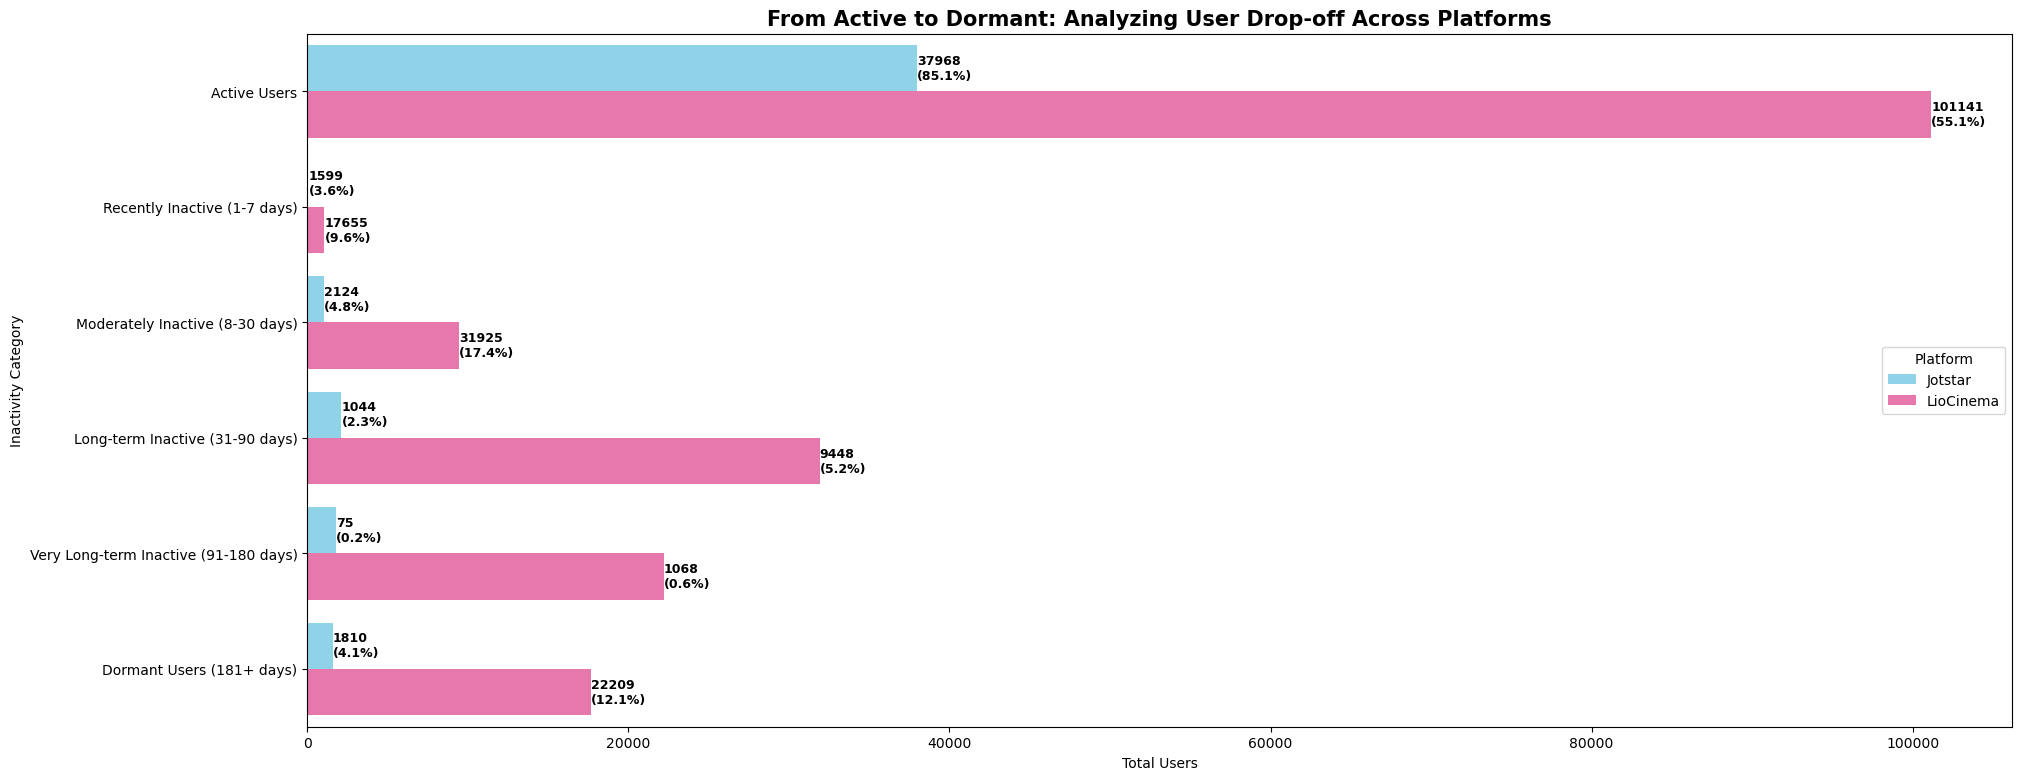

In [8]:
def get_user_count(df):
    temp_df = df[['User ID', 'Last Active Date']].copy()
    '''
    'Days Since Last Activity' represents the number of days that have passed since a user's last recorded activity. 
    It is calculated using December 30, 2024, as the reference date. Users who are still active (i.e., have no recorded last active date) are 
    assigned a value of 0, ensuring a clear distinction between active and inactive users. This metric helps analyze engagement patterns and 
    inactivity trends.
    '''
    def get_days_of_inactivity(df):
        ''' 
        Latest Date in the Last Active Date column is 2024-12-29 so setting reference day as +1 to show Days Since Last Activity for Active 
        Users equal to 0 
        '''
        reference_date = pd.to_datetime("2024-12-30")  
        df["Last Active Date"] = df["Last Active Date"].fillna(reference_date)
        df["Days Since Last Activity"] = (reference_date - df['Last Active Date']).dt.days
        df["Days Since Last Activity"] = df["Days Since Last Activity"].astype(int)
        return df

    temp_df = get_days_of_inactivity(temp_df)
    result = temp_df.groupby(['Days Since Last Activity'])['User ID'].count().reset_index()
    result = result.rename(columns = {'User ID':'Total Users'})
    result['Total Users (%)'] = (result['Total Users'] / (result['Total Users'].sum()))* 100
    return result
    
def categorize_inactivity(days_of_inactivity):
    if days_of_inactivity == 0:
        return "Active Users"
    elif 1 <= days_of_inactivity <= 7:
        return "Recently Inactive (1-7 days)"
    elif 8 <= days_of_inactivity <= 30:
        return "Moderately Inactive (8-30 days)"
    elif 31 <= days_of_inactivity <= 90:
        return "Long-term Inactive (31-90 days)"
    elif 91 <= days_of_inactivity <= 180:
        return "Very Long-term Inactive (91-180 days)"
    else:
        return "Dormant Users (181+ days)"
        
jotstar_temp_df = get_user_count(jotstar_subscribers_df)
jotstar_temp_df['Inactivity Category'] = jotstar_temp_df['Days Since Last Activity'].apply(categorize_inactivity)
jotstar_temp_df['Platform'] = "Jotstar"
liocinema_temp_df = get_user_count(liocinema_subscribers_df)
liocinema_temp_df['Inactivity Category'] = liocinema_temp_df['Days Since Last Activity'].apply(categorize_inactivity)
liocinema_temp_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_temp_df, liocinema_temp_df])

category_order = [
    "Active Users",
    "Recently Inactive (1-7 days)",
    "Moderately Inactive (8-30 days)",
    "Long-term Inactive (31-90 days)",
    "Very Long-term Inactive (91-180 days)",
    "Dormant Users (181+ days)"
]

final_df = merged_df.groupby(['Platform', 'Inactivity Category'])[['Total Users', 'Total Users (%)']].sum().reset_index()
final_df['Inactivity Category'] = pd.Categorical(final_df['Inactivity Category'], categories = category_order, ordered = True)

plt.figure(figsize = (22, 9))
plt.title("From Active to Dormant: Analyzing User Drop-off Across Platforms", fontsize = 15, fontweight = "bold")

bp = sns.barplot(final_df, y = 'Inactivity Category', x = 'Total Users', hue = 'Platform', palette = ["#82D9F5", "#F966AA"], 
                 order = category_order)

for bar, users, pct in zip(bp.patches, final_df['Total Users'], final_df['Total Users (%)']):
    x = bar.get_x() + bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    label = f"{users:.0f}\n({pct:.1f}%)"  
    plt.text(x, y, label, ha = "left", va = "center", fontsize = 9, color = "black", fontweight = "bold")
        
plt.legend(title = "Platform", loc = "center right")

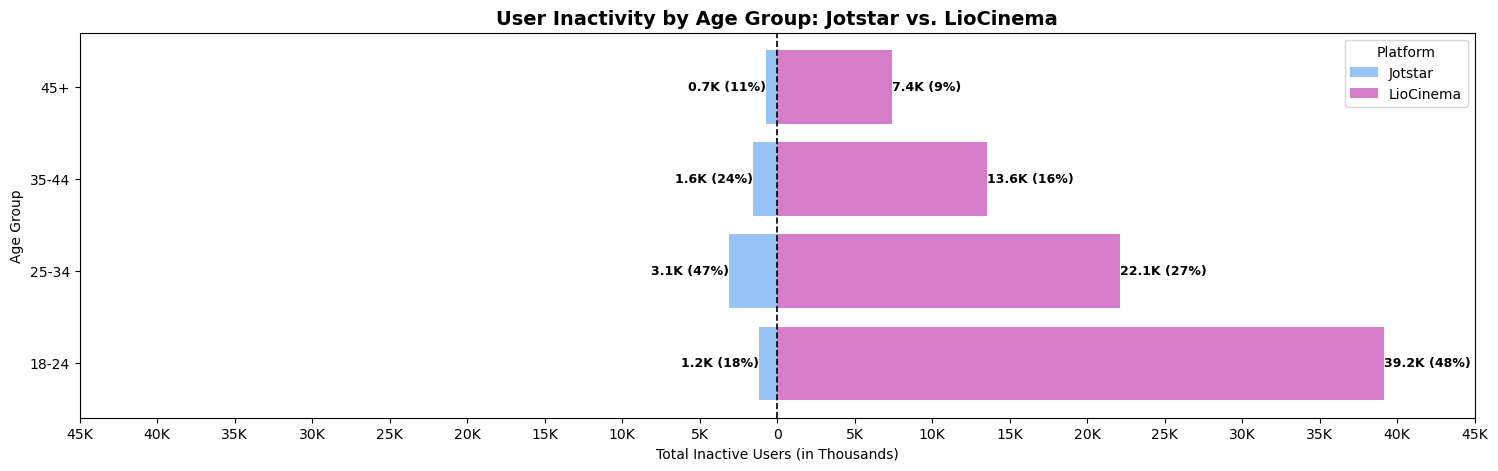

In [9]:
def get_inactive_users_count(df):
    result = df.groupby('Age Group')['Last Active Date'].count()
    result = result.to_frame().rename(columns = {'Last Active Date':'Total Inactive Users'}).reset_index()
    return result
    
jotstar_temp_df = get_inactive_users_count(jotstar_subscribers_df)
jotstar_temp_df['Total Inactive Users'] *= -1
liocinema_temp_df = get_inactive_users_count(liocinema_subscribers_df)

plt.subplots(figsize = (18, 5))
plt.title("User Inactivity by Age Group: Jotstar vs. LioCinema", fontsize = 14, fontweight = "bold")

bars_js = plt.barh(jotstar_temp_df['Age Group'], jotstar_temp_df['Total Inactive Users'], color = "#7FB5F4", label = "Jotstar", alpha = 0.8)

bars_lc = plt.barh(liocinema_temp_df['Age Group'], liocinema_temp_df['Total Inactive Users'], color = "#CB5DBB", label = "LioCinema", 
                   alpha = 0.8)

for bar in bars_js:
    value = (abs(bar.get_width())) / 1000
    pct = ((abs(bar.get_width())) / abs(jotstar_temp_df['Total Inactive Users'].sum()))* 100
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f"{value:.1f}K ({pct:.0f}%)", 
             va = "center", ha = "right", color = "black", fontsize = 9, fontweight = "bold")

for bar in bars_lc:
    value = (bar.get_width()) / 1000
    pct = (bar.get_width() / liocinema_temp_df['Total Inactive Users'].sum())* 100
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,  
             f"{value:.1f}K ({pct:.0f}%)",  
             va = "center", ha = "left", color = "black", fontsize = 9, fontweight = "bold")

plt.xlabel("Total Inactive Users (in Thousands)")
plt.ylabel("Age Group")
plt.axvline(0, color = "black", linewidth = 1.2, linestyle = "dashed")
plt.xticks(ticks = [-45000, -40000, -35000, -30000, -25000, -20000, -15000, -10000, -5000, 0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 
                    40000, 45000], 
           labels = ["45K", "40K", "35K", "30K", "25K", "20K", "15K", "10K", "5K", "0", "5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K",
                     "45K"])
plt.legend(title = "Platform", loc = "upper right")

Text(0, 0.5, 'Total Inactive Users (in Thousands)')

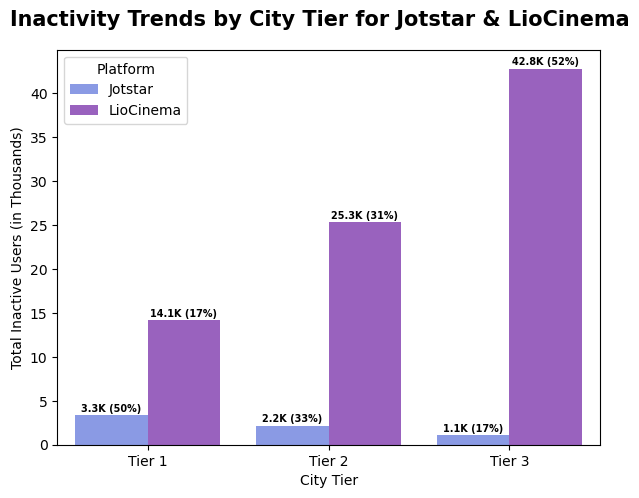

In [10]:
def get_inactive_users_count(df):
    result = df.groupby('City Tier')['Last Active Date'].count()
    result = result.to_frame().rename(columns = {'Last Active Date':'Total Inactive Users'}).reset_index()
    result['Total Inactive Users (%)'] = (result['Total Inactive Users'] / (result['Total Inactive Users'].sum())) * 100
    result['Total Inactive Users'] /= 1000
    return result
    
jotstar_temp_df = get_inactive_users_count(jotstar_subscribers_df)
liocinema_temp_df = get_inactive_users_count(liocinema_subscribers_df)
jotstar_temp_df['Platform'] = "Jotstar"
liocinema_temp_df['Platform'] = "LioCinema"
merged_df = pd.concat([jotstar_temp_df, liocinema_temp_df])

plt.figure(figsize = (7, 5))
plt.subplots_adjust(top = 0.9)
plt.suptitle("Inactivity Trends by City Tier for Jotstar & LioCinema", fontsize = 15, fontweight = "bold", ha = "center")

bp = sns.barplot(merged_df, x = 'City Tier', y = 'Total Inactive Users', hue = 'Platform', palette = ["#7B90F3", "#9C53CD"] )
for bar, content, pct in zip(bp.patches, merged_df['Total Inactive Users'], merged_df['Total Inactive Users (%)']):
    x = bar.get_x() + bar.get_width() / 2  
    y = bar.get_height()
    label = f"{content:.1f}K ({pct:.0f}%)"  
    plt.text(x, y + 1.3, label, ha = "center", va = "top", fontsize = 7, color = "black", fontweight = "bold")
plt.ylabel("Total Inactive Users (in Thousands)")

([<matplotlib.patches.Wedge at 0x21421dfcf20>,
 [Text(-0.7182762700492402, 0.8331141577744019, 'Free'),
  Text(0.5659209500852959, -0.943256846386262, 'Basic'),
  Text(1.0839347431720456, -0.18731116502908057, 'Premium')],
 [Text(-0.45708489912224365, 0.5301635549473466, '4.8K (72.6%)'),
  Text(0.3601315136906428, -0.6002543567912575, '1.5K (21.9%)'),
  Text(0.6897766547458472, -0.11919801410941488, '0.4K (5.4%)')])

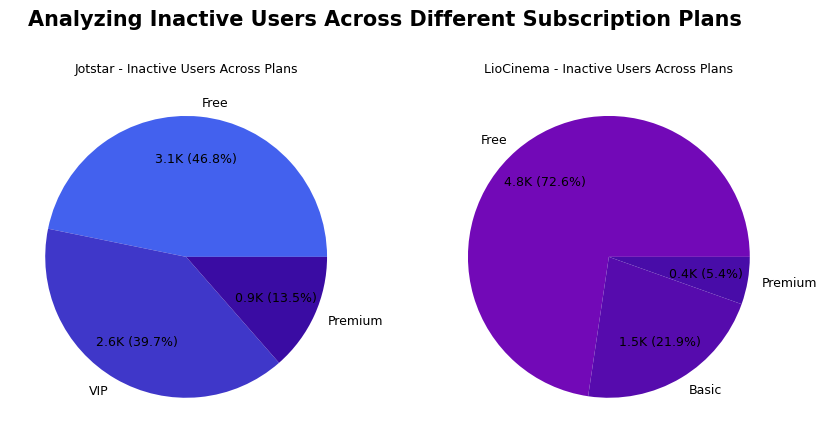

In [11]:
def get_inactive_users_count(df):
    result = df.groupby('New Subscription Plan')['Last Active Date'].count()
    result = result.to_frame()
    result = result.reset_index()
    result = result.rename(columns = {'New Subscription Plan':'Subscription Plan','Last Active Date':'Total Inactive Users'})
    result['Total Inactive Users'] /= 1000
    result = result.sort_values('Total Inactive Users', ascending = False)
    return result
    
jotstar_temp_df = get_inactive_users_count(jotstar_subscribers_df)
liocinema_temp_df = get_inactive_users_count(liocinema_subscribers_df)

def autopct_format(pct, all_vals):
    absolute = round((pct / 100. * sum(all_vals)), 1)
    return f"{absolute}K ({pct:.1f}%)"

plt.figure(figsize = (10, 5))
plt.subplots_adjust(top = 0.86)
plt.suptitle("Analyzing Inactive Users Across Different Subscription Plans", fontsize = 15, fontweight = "bold")

Jotstar = ["#4361EE", "#3F37C9", "#3A0CA3"]
LioCinema = ["#7209B7", "#560BAD", "#480CA8"]

ax1 = plt.subplot(1, 2, 1)
ax1.set_aspect("equal")
plt.title("Jotstar - Inactive Users Across Plans", fontsize = 9)
plt.pie(jotstar_temp_df['Total Inactive Users'], labels = jotstar_temp_df['Subscription Plan'], 
        autopct = lambda pct: autopct_format(pct, jotstar_temp_df['Total Inactive Users']), 
        colors = Jotstar, textprops = {"fontsize": 9}, pctdistance = 0.7)

ax2 = plt.subplot(1, 2, 2)
ax2.set_aspect("equal")
plt.title("LioCinema - Inactive Users Across Plans", fontsize = 9)
plt.pie(liocinema_temp_df['Total Inactive Users'], labels = liocinema_temp_df['Subscription Plan'], 
        autopct = lambda pct: autopct_format(pct, jotstar_temp_df['Total Inactive Users']),
        colors = LioCinema, textprops = {"fontsize": 9}, pctdistance = 0.7)

## Next Notebook: "8. Upgrade Patterns: Who’s Moving Up and Why?"